In [1]:
import re
import itertools
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import seaborn as sns
from scipy import stats
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from pycaret.regression import *
from sklearn.linear_model import LinearRegression

In [2]:
# Time features nr 1
def add_time_features(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  

    # Extract various time features
    df['hour'] = df[time_column].dt.hour
    df['day_of_week'] = df[time_column].dt.dayofweek
    df['month'] = df[time_column].dt.month
    df['day_of_year'] = df[time_column].dt.dayofyear
    df['week_of_year'] = df[time_column].dt.isocalendar().week 
    df['year'] = df[time_column].dt.year
    
    return df

In [3]:
# Time features nr 2
def add_time_features_cat(df, time_column):
    
    df[time_column] = pd.to_datetime(df[time_column])  
    
    df['sin_hour'] = np.sin(np.pi * df[time_column].dt.hour/23.)
    df['sin_month'] = np.sin(np.pi * df[time_column].dt.month/12.)
    
    return df

In [4]:
  
# Make some extra date features that capture the diffrence in obsverved and estimated data
def process_data(observed, estimated, test):
    
    # 1. Create time-delta for estimated data
      estimated['time_dummy'] = (estimated['date_forecast'] - estimated['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      observed['time_dummy'] = 0 
      test['time_dummy'] = (test['date_forecast'] - test['date_forecast'].dt.normalize()).dt.total_seconds() / 3600
      
      estimated['time_delta'] = (estimated['date_calc'] - estimated['date_forecast']).dt.total_seconds() / 3600
      observed['time_delta'] = 0  # since observed data is not forecasting ahead
      test['time_delta'] = (test['date_calc'] - test['date_forecast']).dt.total_seconds() / 3600
      
      # 2. Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1
      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test

In [5]:
# Preprocessing LigtGBM + catboost
def preprocessing(targets, observed, estimated, test,mode = 'lgbm'):
    
    # Ensure the datetime columns are in datetime format
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])
    
    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
 
 
    if mode == 'catboost':
            # Filter observed and estimated data for April to August
        observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
        estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
        test_resampled = test_resampled[test_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    
    # Add extra features
    process_data_func = process_data_cat if mode == 'catboost' else process_data
    weather_data, test_resampled = process_data_func(observed_resampled, estimated_resampled, test_resampled)
    
    # Merge with target values
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')

    # Add the time-based features
    add_time_features_func = add_time_features_cat if mode == 'catboost' else add_time_features
    merged_data = add_time_features_func(merged_data, 'time')  
    test_resampled = add_time_features_func(test_resampled, 'date_forecast') 
    
    # Remove data where targes are zero as its no reason to train for this
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove the constant where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]

    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])
    
    
    # Drop time features
    filtered_data = filtered_data.drop(columns=['time', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast', 'date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### Preprocessing for catboost models

In [6]:
def process_data_cat(observed, estimated, test):
      # Add indicator variable for estimated data
      estimated['is_estimated'] = 1
      observed['is_estimated'] = 0
      test['is_estimated'] = 1

      # Merge or concatenate data
      df = pd.concat([observed, estimated], axis=0).sort_values(by='date_forecast')
      
      return df, test

In [7]:
# Preprocessing nr 2 for catboost models
def preprocessing_cat(targets, observed, estimated, test):
    
    targets['time'] = pd.to_datetime(targets['time'])
    observed['date_forecast'] = pd.to_datetime(observed['date_forecast'])
    estimated['date_forecast'] = pd.to_datetime(estimated['date_forecast'])
    test['date_forecast'] = pd.to_datetime(test['date_forecast'])

    # Start the resampling from 15min to 1 hour
    date_calc_resampled_ob = estimated.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    date_calc_resampled_te = test.set_index('date_forecast')['date_calc'].resample('1H').first().to_frame()
    
    observed_resampled = observed.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    estimated_resampled = estimated.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    test_resampled = test.set_index('date_forecast').resample('1H').mean().dropna(how='all').reset_index()
    
    estimated_resampled = estimated_resampled.merge(date_calc_resampled_ob, left_on='date_forecast', right_index=True)
    test_resampled = test_resampled.merge(date_calc_resampled_te, left_on='date_forecast', right_index=True)
    
    #Save the is_day feature as this says a lot about when the power output is zero or not
    is_day_feature = test_resampled[['date_forecast', 'is_day:idx']]
    
    #Drop some features that is noise
    test_resampled = test_resampled.drop(columns =['is_day:idx', 'snow_density:kgm3','elevation:m'])
    observed_resampled = observed_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])
    estimated_resampled = estimated_resampled.drop(columns =[ 'is_day:idx', 'snow_density:kgm3','elevation:m'])

   
    # Filter observed and estimated data for April to August
    observed_resampled = observed_resampled[observed_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]
    estimated_resampled = estimated_resampled[estimated_resampled['date_forecast'].dt.month.isin([4, 5, 6, 7, 8])]

    # Merge the observed and estimated data
    weather_data, test_resampled = process_data_cat(observed_resampled, estimated_resampled, test_resampled)

    # Merge with target values filtering for the same months
    targets = targets[targets['time'].dt.month.isin([4, 5, 6, 7, 8])]
    
    
    
    merged_data = pd.merge(targets, weather_data, how='inner', left_on='time', right_on='date_forecast')
    merged_data = add_time_features_cat(merged_data, 'time')  
    test_resampled = add_time_features_cat(test_resampled, 'date_forecast')

    # Remove data when targets are zero
    merged_data = merged_data[merged_data['pv_measurement'] != 0]

    # Removing data where the power output is saturated
    # Step 1: Calculate the difference
    merged_data['diff'] = merged_data['pv_measurement'].diff().fillna(0)

    # Step 2: Create an indicator where diff is zero
    merged_data['constant'] = (merged_data['diff'] == 0).astype(int)

    # Step 3: Use the indicator to mark where diff is zero. The diff() function here identifies change-points.
    merged_data['block'] = (merged_data['constant'].diff() != 0).astype(int).cumsum()

    # Get the size of each constant block
    block_sizes = merged_data.groupby('block')['constant'].sum()

    # Identify blocks that are constant for more than 2 consecutive time points (you can adjust this threshold)
    constant_blocks = block_sizes[block_sizes > 2].index

    # Step 4: Remove where diff is zero
    filtered_data = merged_data[~merged_data['block'].isin(constant_blocks)]
    
    # Drop time and temporary features
    targets_ny = filtered_data[ ['time', 'pv_measurement']]
    filtered_data = filtered_data.drop(columns=['diff', 'constant', 'block'])

    start_date = '2017-07-01'  # Replace with desired start date
    end_date = '2024-08-30'  # Replace with desired end date

    if observed_resampled.empty:
        print(f"observed_resampled is empty for location ")
    
    # Drop some time features
    filtered_data = filtered_data.drop(columns=['time', 'date_forecast', 'pv_measurement','date_calc'])
    test_resampled = test_resampled.drop(columns=[ 'date_forecast','date_calc'])
    
    return filtered_data, test_resampled, is_day_feature, targets_ny

### LightGBM with some extra features

In [8]:
# LightGBM with some extra features
def process_location_ex(X, y, location_name,seeds):
    
    # Combine feature data and target into a single DataFrame
    data = X.copy()
    data['target'] = y['pv_measurement']

    # Added some extra features to this one model, did it here so we could reuse the same preprocesssing function on diffrent models
    # Feature Combination 1: Solar Radiation and Cloud Cover Combination
    data['weighted_rad'] = ((data['direct_rad:W'] * (1 - data['total_cloud_cover:p']/100)) +
                        (data['diffuse_rad:W'] * (data['total_cloud_cover:p']/100)))

    # Feature Combination 2: Atmospheric Conditions Combination
    data['adjusted_clear_sky_rad'] = (data['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * data['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (data['air_density_2m:kgm3'] - 1.225)))  # Adjusted based on humidity and air density
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    imputation_type="iterative", categorical_iterative_imputer="lightgbm", numeric_iterative_imputer="lightgbm", iterative_imputation_iters = 5,

                    categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False, 
                    experiment_name=f'exp_{location_name}')

    # Create a LightGBM model
    lightgbm = create_model('lightgbm')
    
    # Tune the model
    tuned_lightgbm = tune_model(lightgbm)#, early_stopping=True, fold=15)

    # Create a bagged version of the tuned model
    bagged_lightgbm = ensemble_model(tuned_lightgbm, method='Bagging')

    # Finalize the model by training on whole dataset
    final_model = finalize_model(bagged_lightgbm)
    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

### Catboost model nr 2

In [9]:
# Catboost model nr 2
def process_location_cat_2(X, y, location_name,seeds):
    
    # Dropping some features for this one model
    features_to_drop = ['dew_or_rime:idx', #'snow_density:kgm3',
                        'fresh_snow_3h:cm', 'fresh_snow_1h:cm', 'snow_drift:idx', 
                        'snow_depth:cm', 'wind_speed_w_1000hPa:ms', 'prob_rime:p', 
                        'fresh_snow_6h:cm', 'snow_melt_10min:mm', 
                        'fresh_snow_12h:cm', 'rain_water:kgm2', 
                        'super_cooled_liquid_water:kgm2']
    
    X = X.drop(columns=features_to_drop)
    
    data = X.copy()
    data['target'] = y['pv_measurement']
    
    # Setup the environment in PyCaret
    exp_reg = setup(data=data, target='target', session_id=seeds,
                    imputation_type="iterative", categorical_iterative_imputer="lightgbm", numeric_iterative_imputer="lightgbm", iterative_imputation_iters = 5,

                    #categorical_features=['dew_or_rime:idx', 'is_in_shadow:idx','is_estimated'],
                    #remove_outliers=True,  #Ble dårligere med denne
                    html=False,
                    experiment_name=f'exp_{location_name}')

    # Create a Catboost model
    cat = create_model('catboost')

    # Tune the model
    tuned_cat = tune_model(cat)
    
    # Create a bagged version of the tuned model
    bagged_cat = ensemble_model(tuned_cat, method='Bagging')

    # Train on whole dataset
    final_model = finalize_model(bagged_cat)

    # Save the model for future use
    save_model(final_model, f'final_model_for_location_{location_name}')
        
    return final_model

#### Initializing lists and dataframes for storing predictions

In [10]:
# Some global lists to save predictions in
locations = ['A']
all_predictions_lGBM = []

all_predictions_rf = []
all_predictions_lasso = []


final_df_list = [] 
all_pred_stacked =[]
all_predictions_cat_3=[]

all_X_train_cat = pd.DataFrame()
all_X_test_cat = pd.DataFrame()
all_is_day_feature1 = pd.Series(dtype='float64')
all_targets_cat = pd.DataFrame()

# Training and predictions

### LightGBM

In [11]:
# LightGBM training and predictions
all_predictions_lGBM_e = []
for loc in locations:

    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')
    
    # Calling preprocessing
    X_train_1, X_test_1, is_day_feature_1, targets_1 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    
    # Adding the extra features to the test set as well
    X_train_1 = X_train_1.drop(columns=['date_forecast'])
    X_test_1['weighted_rad'] = ((X_test_1['direct_rad:W'] * (1 - X_test_1['total_cloud_cover:p']/100)) +
                        (X_test_1['diffuse_rad:W'] * (X_test_1['total_cloud_cover:p']/100)))

    X_test_1['adjusted_clear_sky_rad'] = (X_test_1['clear_sky_rad:W'] *
                                  np.exp(-0.0001 * X_test_1['absolute_humidity_2m:gm3']) *
                                  (1 - 0.1 * (X_test_1['air_density_2m:kgm3'] - 1.225)))
    
    # Training and prediction for diffrent seeds
    total_predictions_light = None
    seeds = [42]
    for seed in seeds: 
        final_model_lGBM_e = process_location_ex(X_train_1, targets_1, loc, seed)
        predictions_lGBM_e = predict_model(final_model_lGBM_e, data=X_test_1)
        final_predictions_lGBM_e = predictions_lGBM_e['prediction_label']
        if total_predictions_light is None:
            total_predictions_light = np.zeros_like(final_predictions_lGBM_e)
        total_predictions_light += final_predictions_lGBM_e

    mean_pred_light = total_predictions_light/len(seeds)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_lGBM_e = mean_pred_light * is_day_feature_1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_lGBM_e = np.clip(adjusted_final_predictions_lGBM_e, 0, None)

    # Appening predictions for each location to final list
    all_predictions_lGBM_e.append([adjusted_final_predictions_lGBM_e])

# Changing final list to array
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e)

                        Description        Value
0                        Session id           42
1                            Target       target
2                       Target type   Regression
3               Original data shape  (18038, 54)
4            Transformed data shape  (18038, 66)
5       Transformed train set shape  (12626, 66)
6        Transformed test set shape   (5412, 66)
7                  Ordinal features            1
8                  Numeric features           50
9              Categorical features            3
10         Rows with missing values        19.9%
11                       Preprocess         True
12                  Imputation type    iterative
13  Iterative imputation iterations            5
14        Numeric iterative imputer     lightgbm
15    Categorical iterative imputer     lightgbm
16         Maximum one-hot encoding           25
17                  Encoding method         None
18                   Fold Generator        KFold
19                  

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     343.0199  308740.9453  555.6446  0.8363  0.9011  3.0997
1     337.5402  306705.5448  553.8100  0.8396  0.7952  2.1846
2     334.7009  297845.3386  545.7521  0.8499  0.8064  1.9967
3     344.4211  314486.7676  560.7912  0.8410  0.8604  2.7933
4     318.3007  271959.2162  521.4971  0.8514  0.9047  3.0527
5     347.4846  308072.8997  555.0432  0.8397  0.8798  2.6893
6     341.8247  303858.2592  551.2334  0.8251  0.9114  3.1499
7     347.6177  309168.8913  556.0296  0.8409  0.8466  2.4500
8     303.6504  240920.1210  490.8361  0.8661  0.8356  2.5678
9     326.0613  288131.4081  536.7787  0.8477  0.8301  2.5978
Mean  334.4621  294988.9392  542.7416  0.8438  0.8571  2.6582
Std    13.6379   21602.0317   20.5059  0.0103  0.0392  0.3645


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     340.1721  299680.4553  547.4308  0.8411  0.9661  4.2752
1     344.3137  309613.8671  556.4296  0.8381  0.8615  2.5332
2     340.5793  306529.3593  553.6509  0.8456  0.8449  1.9673
3     339.6676  302594.8706  550.0862  0.8470  0.8800  3.0080
4     322.5076  279541.2181  528.7166  0.8473  0.9330  3.1220
5     351.0241  306299.0774  553.4429  0.8407  0.9301  3.5666
6     344.5513  307061.9856  554.1317  0.8232  0.9327  3.4149
7     344.6861  313506.6860  559.9167  0.8386  0.8799  2.9408
8     300.5692  238811.5553  488.6835  0.8672  0.8951  3.2937
9     318.4328  276831.3434  526.1476  0.8537  0.9131  3.1709
Mean  334.6504  294047.0418  541.8637  0.8442  0.9036  3.1293
Std    14.9098   21814.8392   20.7561  0.0108  0.0358  0.5806


           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     329.4455  283530.7764  532.4761  0.8496  0.8797  3.2855
1     330.8892  288854.7799  537.4521  0.8490  0.7959  2.1113
2     333.8657  300975.8738  548.6127  0.8484  0.8145  1.8647
3     337.0255  303563.0383  550.9656  0.8465  0.8582  2.8491
4     312.0093  264065.9680  513.8735  0.8557  0.8858  2.6833
5     340.4875  292427.9278  540.7661  0.8479  0.8711  2.9202
6     331.6774  286577.8131  535.3296  0.8350  0.8492  2.3828
7     339.9131  297160.8284  545.1246  0.8470  0.8496  2.3176
8     295.1791  232207.9046  481.8796  0.8709  0.8744  3.0802
9     314.8125  269347.8708  518.9874  0.8577  0.8174  2.5069
Mean  326.5305  281871.2781  530.5467  0.8508  0.8496  2.6002
Std    13.8669   20481.0190   19.7855  0.0088  0.0292  0.4227
Transformation Pipeline and Model Successfully Saved
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be 

### Catboost model nr 1

In [26]:
from sklearn.impute import IterativeImputer
all_predictions_cat = []
# Catboost model nr 1
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_cat, X_test_cat, is_day_feature1, targets_cat = preprocessing_cat(train, X_train_observed, X_train_estimated, X_test_estimated)
 
    # Making categorical features
    cat_features = ['dew_or_rime:idx' ,'is_in_shadow:idx']
    X_train_cat['dew_or_rime:idx'] = X_train_cat['dew_or_rime:idx'].astype(int)
    X_train_cat['is_in_shadow:idx'] = X_train_cat['is_in_shadow:idx'].astype(int)
    X_test_cat['dew_or_rime:idx'] = X_test_cat['dew_or_rime:idx'].astype(int)
    X_test_cat['is_in_shadow:idx'] = X_test_cat['is_in_shadow:idx'].astype(int)

    # Catboooooooozt fun
    model_cat = CatBoostRegressor(
        loss_function='MAE', 
        learning_rate=0.1, 
        verbose=200,
        cat_features=cat_features,
        random_state=42) 
        #n_estimators=20000,
        #early_stopping_rounds=50,)

    #X_train_cat1, X_val_cat1, y_train_cat1, y_val_cat1 = train_test_split(X_train_cat, targets_cat, test_size=0.2, random_state=42)
    
    # Training
    model_cat.fit(X_train_cat,targets_cat['pv_measurement']) #X_train_cat1, y_train_cat1['pv_measurement'],eval_set=(X_val_cat1, y_val_cat1['pv_measurement']),)

    # Prediction
    predictions_cat = model_cat.predict(X_test_cat[model_cat.feature_names_])
    feature_importances = model_cat.get_feature_importance()
    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat = predictions_cat * is_day_feature1['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat = np.clip(adjusted_final_predictions_cat, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat.append(adjusted_final_predictions_cat)

# Changing final list to array
all_predictions_cat = np.array(all_predictions_cat)

0:	learn: 1098.0450846	total: 35.7ms	remaining: 35.7s
200:	learn: 364.8966719	total: 9.17s	remaining: 36.5s
400:	learn: 328.6032161	total: 17.6s	remaining: 26.3s
600:	learn: 306.8253447	total: 25.6s	remaining: 17s
800:	learn: 291.9455358	total: 33.6s	remaining: 8.36s
999:	learn: 280.1029739	total: 41.6s	remaining: 0us


In [14]:
X_test_cat.isna().sum()

absolute_humidity_2m:gm3            0
air_density_2m:kgm3                 0
ceiling_height_agl:m              188
clear_sky_energy_1h:J               0
clear_sky_rad:W                     0
cloud_base_agl:m                   70
dew_or_rime:idx                     0
dew_point_2m:K                      0
diffuse_rad:W                       0
diffuse_rad_1h:J                    0
direct_rad:W                        0
direct_rad_1h:J                     0
effective_cloud_cover:p             0
fresh_snow_12h:cm                   0
fresh_snow_1h:cm                    0
fresh_snow_24h:cm                   0
fresh_snow_3h:cm                    0
fresh_snow_6h:cm                    0
is_in_shadow:idx                    0
msl_pressure:hPa                    0
precip_5min:mm                      0
precip_type_5min:idx                0
pressure_100m:hPa                   0
pressure_50m:hPa                    0
prob_rime:p                         0
rain_water:kgm2                     0
relative_hum

### Catboost model nr 2

In [20]:
all_predictions_cat_2 = []
# Catboost model nr 2
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train, X_test, is_day_feature, targets = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)

    # Dropping some winter months
    X_train_cat_2 = X_train#[X_train['date_forecast'].dt.month.isin([3,4, 5, 6, 7, 8, 9,10])]

    # Dropping date feature
    X_train_cat_2 = X_train_cat_2.drop(columns=['date_forecast'])

    # Training and prediction for diffrent seeds
    seeds = [42]
    total_predictions_cat_2 = None
    for seed in seeds: 
        final_model_cat_2 = process_location_cat_2(X_train_cat_2, targets, loc,seed)#its aactually a catboost wohoo
        predictions_cat_2 = predict_model(final_model_cat_2, X_test)
        final_predictions_cat_2 = predictions_cat_2['prediction_label']
        if total_predictions_cat_2 is None:
            total_predictions_cat_2 = np.zeros_like(final_predictions_cat_2)
            total_predictions_cat_2+=final_predictions_cat_2

    mean_pred_cat_2 = total_predictions_cat_2/len(seeds)

    adjusted_final_predictions_cat_2 = mean_pred_cat_2 * is_day_feature['is_day:idx']
    adjusted_final_predictions_cat_2 = np.clip(adjusted_final_predictions_cat_2, 0, None)
    all_predictions_cat_2.append([adjusted_final_predictions_cat_2])
all_predictions_cat_2 = np.array(all_predictions_cat_2)

                        Description        Value
0                        Session id           42
1                            Target       target
2                       Target type   Regression
3               Original data shape  (18038, 40)
4            Transformed data shape  (18038, 40)
5       Transformed train set shape  (12626, 40)
6        Transformed test set shape   (5412, 40)
7                  Numeric features           39
8          Rows with missing values        19.9%
9                        Preprocess         True
10                  Imputation type    iterative
11  Iterative imputation iterations            5
12        Numeric iterative imputer     lightgbm
13    Categorical iterative imputer     lightgbm
14                   Fold Generator        KFold
15                      Fold Number           10
16                         CPU Jobs           -1
17                          Use GPU        False
18                   Log Experiment        False
19                  

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     331.5347  280088.3061  529.2337  0.8515  0.9573  4.4094
1     329.8633  282572.0687  531.5751  0.8523  0.9035  2.8594
2     330.1709  281579.4527  530.6406  0.8581  0.9094  3.5294
3     340.2220  302901.1310  550.3645  0.8468  0.9635  4.2181
4     311.7154  258253.4291  508.1864  0.8589  0.9887  4.1276
5     332.0868  275836.8078  525.2017  0.8565  0.9528  3.9372
6     327.8728  288634.4182  537.2471  0.8338  0.9640  3.7622
7     343.9738  296294.5591  544.3295  0.8475  0.9642  4.1479
8     297.9808  225688.0367  475.0663  0.8745  0.9624  4.6959
9     317.6170  273433.8230  522.9090  0.8555  0.9261  3.9950
Mean  326.3038  276528.2032  525.4754  0.8535  0.9492  3.9682
Std    12.9897   20582.1803   20.0952  0.0099  0.0258  0.4807


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).
           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     373.7750  347800.1610  589.7458  0.8155  0.9998  5.4426
1     376.3020  357862.4528  598.2161  0.8129  0.9240  3.4955
2     372.8907  353602.6585  594.6450  0.8219  0.9237  2.8008
3     369.0966  350865.7319  592.3392  0.8226  0.9733  4.1112
4     350.0916  314306.3659  560.6303  0.8283  1.0124  4.6743
5     383.1707  355459.8671  596.2046  0.8151  0.9840  4.2884
6     374.6368  349193.2898  590.9258  0.7989  1.0071  5.1602
7     394.0195  374185.4020  611.7070  0.8074  0.9794  3.5532
8     327.8279  282676.6929  531.6735  0.8428  0.9712  4.4658
9     362.1430  330657.0625  575.0279  0.8252  0.9519  4.1905
Mean  368.3954  341660.9684  584.1115  0.8191  0.9727  4.2183
Std    17.4524   24861.6143   21.7879  0.0115

           MAE          MSE      RMSE      R2   RMSLE    MAPE
Fold                                                         
0     330.8393  280379.3867  529.5086  0.8513  0.9278  3.9378
1     331.4055  288341.1455  536.9741  0.8492  0.8880  2.8825
2     329.2066  290338.0350  538.8302  0.8537  0.8742  2.9036
3     335.5599  298457.0409  546.3122  0.8491  0.8987  3.7164
4     309.5971  261297.1835  511.1724  0.8572  0.9686  3.5521
5     334.3443  281169.8822  530.2545  0.8537  0.8949  3.3587
6     330.4999  288589.0153  537.2048  0.8338  0.9092  3.3626
7     344.4032  303321.0872  550.7459  0.8439  0.9245  3.4580
8     295.8456  228783.1977  478.3129  0.8728  0.9317  3.9928
9     314.2570  266088.7083  515.8379  0.8594  0.9046  3.1702
Mean  325.5958  278676.4682  527.5154  0.8524  0.9122  3.4335
Std    13.7749   20700.8013   20.1002  0.0096  0.0256  0.3642
Transformation Pipeline and Model Successfully Saved


### Catboost model nr 3

In [21]:
# Catboost model nr 3
for loc in locations:
    
    # Load your data
    train = pd.read_parquet(f'{loc}/train_targets.parquet').fillna(0)
    X_train_estimated = pd.read_parquet(f'{loc}/X_train_estimated.parquet')
    X_train_observed = pd.read_parquet(f'{loc}/X_train_observed.parquet')
    X_test_estimated = pd.read_parquet(f'{loc}/X_test_estimated.parquet')

    # Calling preprocessing
    X_train_3, X_test_3, is_day_feature_3, targets_3 = preprocessing(train, X_train_observed, X_train_estimated, X_test_estimated)
    imputer = IterativeImputer(max_iter=5, random_state=42)
    for col in X_train_3.columns:
            X_train_3[col] = imputer.fit_transform(np.array(X_train_3[col]).reshape(-1,1))
    for col in X_test_3.columns:
            X_test_3[col] = imputer.fit_transform(np.array(X_test_3[col]).reshape(-1,1))
    # Dropping date feature
    X_train_3 = X_train_3.drop(columns=['date_forecast'])
    
    # Catboooooooozt fun round 3 wohoo
    model_cat_3 = CatBoostRegressor(
    verbose=200, 
    learning_rate=0.03,
    depth=10,
    l2_leaf_reg=5,
    random_state=42, 
    n_estimators=20000, 
    loss_function='MAE', 
    early_stopping_rounds=100,)

    # Create 'sin_sun_azimuth' and 'cos_sun_azimuth' from 'sun_azimuth' in radians
    X_train_3['sin_sun_azimuth'] = np.sin(np.radians(X_train_3['sun_azimuth:d']))
    X_train_3['cos_sun_azimuth'] = np.cos(np.radians(X_train_3['sun_azimuth:d']))
    X_test_3['sin_sun_azimuth'] = np.sin(np.radians(X_test_3['sun_azimuth:d']))
    X_test_3['cos_sun_azimuth'] = np.cos(np.radians(X_test_3['sun_azimuth:d']))

    # Now drop the original 'sun_azimuth' feature
    X_train_3.drop('sun_azimuth:d', axis=1, inplace=True)
    X_test_3.drop('sun_azimuth:d', axis=1, inplace=True)

    # Split the training data into training and validation sets
    X_train_cat_3, X_test_cat_3, y_train_cat_3, y_test_cat_3 = train_test_split(X_train_3, targets_3, test_size=0.2, random_state=42)

    # Train model
    model_cat_3.fit(X_train_cat_3, y_train_cat_3['pv_measurement'],eval_set=(X_test_cat_3, y_test_cat_3['pv_measurement']),)  
    
    # Pred
    pred_cat_3 = model_cat_3.predict(X_test_3)

    # Multiplying the predictions with is_day, so setting predictions at night to zero
    adjusted_final_predictions_cat_3 = pred_cat_3 * is_day_feature_3['is_day:idx']

    # Setting negative predictions to zero
    adjusted_final_predictions_cat_3 = np.clip(adjusted_final_predictions_cat_3, 0, None)

    # Appening predictions for each location to final list
    all_predictions_cat_3.append(adjusted_final_predictions_cat_3) 

# Changing final list to array   
all_predictions_cat_3 = np.array(all_predictions_cat_3)

0:	learn: 981.0541229	test: 986.5219433	best: 986.5219433 (0)	total: 84.6ms	remaining: 28m 12s
200:	learn: 320.2176809	test: 341.2544277	best: 341.2544277 (200)	total: 17.8s	remaining: 29m 14s
400:	learn: 281.1911532	test: 323.6277421	best: 323.6277421 (400)	total: 33.5s	remaining: 27m 17s
600:	learn: 245.3462160	test: 312.6110867	best: 312.6110867 (600)	total: 52s	remaining: 27m 59s
800:	learn: 220.6610225	test: 305.9131406	best: 305.9131406 (800)	total: 1m 8s	remaining: 27m 28s
1000:	learn: 203.5399096	test: 301.8635700	best: 301.8631185 (998)	total: 1m 25s	remaining: 26m 56s
1200:	learn: 186.5319619	test: 299.2329930	best: 299.2077734 (1199)	total: 1m 40s	remaining: 26m 20s
1400:	learn: 170.0942981	test: 297.1414099	best: 297.1032730 (1396)	total: 1m 55s	remaining: 25m 39s
1600:	learn: 158.0310686	test: 295.2505479	best: 295.2474556 (1599)	total: 2m 11s	remaining: 25m 6s
1800:	learn: 146.9404625	test: 293.7430884	best: 293.7430884 (1800)	total: 2m 27s	remaining: 24m 48s
2000:	learn:

# Combining Model Predictions

In [28]:
all_predictions_lGBM_e = np.array(all_predictions_lGBM_e).flatten()
#all_predictions_rf = np.array(all_predictions_rf).flatten()
all_predictions_cat = np.array(all_predictions_cat).flatten()
all_predictions_cat_2 = np.array(all_predictions_cat_2).flatten()
all_predictions_cat_3 = np.array(all_predictions_cat_3).flatten()
#all_pred_stacked = np.array(all_pred_stacked).flatten()
all_pred = 0.25*all_predictions_cat+0.25 * all_predictions_lGBM_e+ 0.25* all_predictions_cat_2+0.25*all_predictions_cat_3#+ 0.1*all_predictions_rf#+ 0.45*all_predictions_lGBM  +  0.1*all_predictions_cat + 0.25*all_predictions_lasso + 0.1*all_predictions_rf
all_pred[all_pred < 6] = 0
print(all_pred.shape)

(720,)


#### Saving the final predictions to CSV

In [29]:
'''sample_submission = pd.read_csv('sample_submission.csv')
sample_submission
sample_submission = sample_submission[['id']].merge(final_df[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv('my_first_submission.csv', index=False)'''

final_predictions = all_pred

# Save the final_predictions to CSV
df = pd.DataFrame(final_predictions, columns=['prediction'])
df['id'] = df.index
df = df[['id', 'prediction']]
#df.to_csv('final_predictions.csv', index=False)

<Axes: >

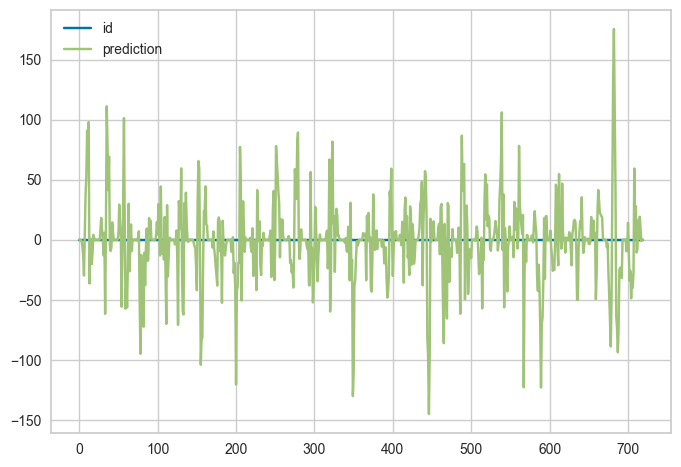

In [30]:
df1 = pd.read_csv('final_predictions_ok.csv')

# create a new dataframe with the difference between df1 and df2
diff_df = df1[0:720] - df

# plot the difference dataframe
diff_df.plot()
